
![ds for good](https://raw.githubusercontent.com/InFoCusp/kaggle_images/master/image1.png)

### Problem statement

In this notebook, we propose some solutions to address the problem that NYC high schools are facing as explained by PASSNYC:
* There is a vast ethnic disparity in the percentage of students registering for/ clearing [Specialized High Schools Admissions Test (SHSAT)](https://www.schools.nyc.gov/school-life/learning/testing/specialized-high-school-admissions-test). This has resulted in lack of diversity in the students that attend the specialized high schools which offer admissions based on the results of SHSAT.
This is a long standing problem in the elite high schools of the city. ([Report](https://www.nytimes.com/2008/11/08/nyregion/08specialized.html) highlighting the same issue from over a decade ago).

### Notable facts
Some facts about SHSAT which will be explain the relevance of the problem and would be helpful in understanding the observations posted below:
* Specialized High Schools Admissions Test is the admissions criterion for eight of the nine specialized high schools
* Students of class 8 and 9 are eligible to appear in the test. The only way to register for the SHSAT is through your middle school guidance counselor. 
* There are two SHSAT sections: English Language Arts (ELA) and Math
* The three highest-status schools—Stuyvesant, Bronx Science, and Brooklyn Tech—have black and Latino student populations of 4, 9, and 13 percent, respectively, far below the 70 percent in public schools citywide.

### Our analysis/ Proposed solution metrics
We analyse the cause for the low percentage of black/ hispanic students appearing for and clearing the test. Based on this analysis, we also suggest solutions which can help bring more diversity into these specialized high schools. We attempt to: <br>
 a) Identify schools with students who are eligible for SHSAT <br>
 b) Identify possible reasons for underperformance/ non appearance in SHSAT <br>
 c) Analyse factors like Economic need index, crime rate, low attendance, etc. for low performing schools <br/>
 d) Pinpoint the key improvements needed in those schools <br>
 e) Explain the rational/ statistics behind each of the decisions <br>
 f) Identify ideal locations for resource centers/ learning centers which could serve multiple schools concurrently by being easily reachable from those
 
 
### References
[This article](https://www.theatlantic.com/education/archive/2018/06/new-york-high-schools-stuyvesant-brooklyn-bronx/562772/) is a very good read for people who wish to understand the problem in more detail and how it was originated. <br/>
[Eight elite high schools admissions details](https://nypost.com/2015/09/27/the-elite-eight-here-are-the-top-schools-in-nyc/) <br/>
[Older report](https://www.nytimes.com/2008/11/08/nyregion/08specialized.html) highlighting the same issue <br/>


![kaggle_homepage](https://raw.githubusercontent.com/InFoCusp/kaggle_images/master/kaggle_homepage.png)


### About the dataset
2 files have been provided
1. <b> 2016 School Explorer.csv </b> : Contains 1272 rows, each describing a separate school in terms of its 161 features which include
    * Locality information (Lat/ Long/ ZIP/ Address/ City (45 unique cities) / District (32)/ SED code (unique to school) )
    * Students of each ethnicity registered in ELA/ Maths in different grades
    * School evaluation metrics
    * ELL(English Language Learners) information
    * Economin Need Index 
    * Attendance Information
            
2. <b> D5 SHSAT Registrations and Testers.csv </b> : Contains information on the students of 30 schools of district 5 who registered for/ actually appeared for SHSAT, along with the breakdown by ethnicity.
 

### First things first 

The eligibility criterion for SHSAT is : Grade 8/9 students
* Of the total 1272 schools, only 619 schools have classes beyond grade 5. Hence, for the initial part of the analsis, we have focused on schools which have students eligible for SHSAT. 
* We understand that the other schools are also relevant as they provide the primary education on which the next ones build but we will come to those later on in the notebook. (Coming Soon)

Our analysis includes the follwing points:
1. [City wise School distribution](#1)
1. [Attacking the absent ratio](#2)
1. [School performance Indicator](#3)
1. [Economic Need Index](#4)
1. [Schools where large percentage of the students are black / hispanic and their proportion in students scoring 4s scores are low](#5)
1. [Crime and safety analysis](#6)
1. [Teacher to student ratio](#7)
1. [ENI / SPI based clustering](#8)
1. [SHSAT Data Analysis](#9)


<h3><a id="1"> City wise School distribution </a> </h3>

![nyc_boroughs](https://raw.githubusercontent.com/InFoCusp/kaggle_images/master/nycburoughs.png)
<b><div  style= "text-align:center"> Map of new york  </div></b>

In [ ]:
%matplotlib inline

# import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
import folium
import sklearn
import seaborn as sns
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.decomposition import PCA
import sklearn
from sklearn.cluster import KMeans
import warnings
import itertools
import base64
from IPython.display import HTML

warnings.filterwarnings('ignore')
init_notebook_mode(connected=True)

In [ ]:
# Function converting string % values to int
def percent_to_int(df_in):
    for col in df_in.columns.values:
        if col.startswith("Percent") or col.endswith("%") or col.endswith("Rate"):
            df_in[col] = df_in[col].astype(np.object).str.replace('%', '').astype(float)
    return df_in

Limiting initial analysis to schools with students who could be prepared for/ are eigible for SHSAT. 

In [ ]:
df_schools_raw = pd.read_csv('../input/data-science-for-good/2016 School Explorer.csv')
df_schools_raw = df_schools_raw[df_schools_raw['Grade High'] != '0K'] 
df_schools_raw = percent_to_int(df_schools_raw)
df_schools_raw['School Income Estimate'] = df_schools_raw['School Income Estimate'].astype(np.object).str.replace('$', '').str.replace(',', '').str.replace('.', '').astype(float)

df_schools_relevant_grade = df_schools_raw[df_schools_raw['Grade High'].astype(int) > 5]

high_nan_columns = df_schools_raw.columns[df_schools_raw.isnull().mean()>0.95]
# print("Here are the fields having >95% NaNs which we can drop: \n")
# print(list(high_nan_columns))

df_schools = df_schools_relevant_grade.drop(high_nan_columns, axis=1)
print("We have %d relevant schools and %d fields describing the school/ students"%(df_schools.shape))

In [ ]:
def plot_city_hist(df_schools, title_str):
    layout = go.Layout(
        title=title_str,
        xaxis=dict(
            title='City',
            titlefont=dict(
                family='Arial, sans-serif',
                size=12,
                color='black'
            ),
            showticklabels=True,
            tickangle=315,
            tickfont=dict(
                size=10,
                color='grey'
            )
        )
    )
    data = [go.Histogram(x=df_schools['City'])]
    fig = go.Figure(data=data, layout=layout)
    return fig

In [ ]:
fig = plot_city_hist(df_schools, 'City wise School Distribution')
iplot(fig)

As shown in the above histogram, the most number of schools with SHSAT eligible students are in Brooklyn, Bronx and New York

<h3><a id="2"> Attacking the absent ratio </a> </h3>

The first and foremost aspect of the schools that we wish to address is the "chronically absent ratio" - if the number is too high for any given school - then the chances of improving that school, even by providing variety of resources would be very low. So, first we identify schools which have >40% of students being chronically absent.

![Attacking_the_absent_ratio_40](https://raw.githubusercontent.com/InFoCusp/kaggle_images/master/attackingtheabsentratio.jpg)



In [ ]:
plt.figure(figsize = [10,8])
df_schools = df_schools.dropna(subset = ['Percent of Students Chronically Absent'])
temp = sns.distplot(df_schools[['Percent of Students Chronically Absent']].values, kde=False)
temp = plt.title('Distribution of schools based on chronically absent students')
temp = plt.xlabel("Percent of students")
temp = plt.ylabel("Count")

In [ ]:
chronically_absent_foi = ['School Name', 'Percent of Students Chronically Absent','Percent Black / Hispanic','Economic Need Index']

df_schools_ca = df_schools[df_schools['Percent of Students Chronically Absent'] > 40]
df_schools_nca = df_schools[df_schools['Percent of Students Chronically Absent'] < 5]

df_schools_ca[chronically_absent_foi].sort_values('Percent of Students Chronically Absent', ascending = False)

In [ ]:
plt.figure(figsize = [16,7])
plt.suptitle('Statistics for schools with high Chronically absent percentage', fontsize=15)
plt.subplot(1,2,1)
temp = sns.distplot(df_schools_ca[['Economic Need Index']].values, kde=False)
temp = plt.xlabel("Economic Need Index", fontsize=15)
temp = plt.ylabel("School count", fontsize=15)
plt.subplot(1,2,2)
temp = sns.distplot(df_schools_ca[['Percent Black / Hispanic']].values, kde=False)
temp = plt.xlabel("Percent Black / Hispanic", fontsize=15)
temp = plt.ylabel("School count", fontsize=15)

In [ ]:
print ('1) ENI Statistics for schools with high % of chronically absent students')
print ('\t * Mean value : %f'%df_schools_ca['Economic Need Index'].mean())
print ('\t * Median value : %f'%df_schools_ca['Economic Need Index'].median())
print('2) %d schools have > 40%% students chronically absent'%(df_schools_ca.shape[0]))

<b>Looking at the above statistics, we can see that, for the schools that have high percentage of chronically absent students:</b>
* Percentage of Black/Hispanic students is high
* Economic Need Index is high

### Suggestions
Our suggestion is to look into the cause for high number of absentees and introduce more outreach programs here. Also, the school counsellor might be able to give insights into the cause of high number of chronically absent students.

<h3><a id="3">School performance Indicator</a></h3>

![School Performance Indicator](https://raw.githubusercontent.com/InFoCusp/kaggle_images/master/School%20%20Performance%20%20Indicator.png)


Next, we explore the 6 fields in the dataset which are indicative of the overall standing of the school. These features include:
* <b>Rigorous Instruction %</b> - Degree to which school curriculum and instructions engage students by fostering critical thinking.
* <b>Collaborative Teachers %</b> - Degree to which teachers participate in development, growth and contribution towards students and school.
* <b>Supportive Environment %</b> - Degree to which school establishes a culture where students feel safe and challenged to grow.
* <b>Effective School Leadership %</b> - Degree to which there is an instructional vision and the leadership is distributed for realising this vision.
* <b>Strong Family-Community Ties %</b> - Degree to which a school works in partnerships with families and other organizations to improve the school.
* <b>Trust %</b> - Degree of relationships of a school with students, teachers, families and adminstrators. 

[comment]:![SPI.jpg](attachment:SPI.jpg)

We show some typical values of these measures below:

In [ ]:
features_list = ['Rigorous Instruction %',
'Collaborative Teachers %',
'Supportive Environment %',
'Effective School Leadership %',
'Strong Family-Community Ties %',
'Trust %']

df_schools[['School Name'] + features_list ].head()

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
for i in range(3):
    for j in range(2):
        ax[i, j].set_title(features_list[i*2 + j])
        sns.distplot(a=df_schools[features_list[i*2 + j]].dropna().values, kde_kws={"color": "red"}, color='darkblue', ax=ax[i, j])

# fig.tight_layout()
temp = fig.suptitle('School Performance features', fontsize=15)

#### Let's look at the correlation between these features.

In [ ]:
df_schools[features_list].corr()

In [ ]:
corr = df_schools[features_list].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='YlGnBu')
temp = plt.xticks(rotation=75, fontsize=15) 
temp = plt.yticks(fontsize=15) 

There is a high correlation was found between three of the features: 
* Effective School Leadership 
* Collaborative Teachers and
* Trust <br/>

'Principal Component Anaysis (PCA)' has been applied on the 3 features to get a single combined feature capturing the key characteristics of all those three features.

In [ ]:
correlated_features_list = ["Effective School Leadership %","Collaborative Teachers %","Trust %"]
corr_features_values = df_schools[correlated_features_list].values

pca = PCA(n_components=1)
combined_feature_value = pca.fit_transform(corr_features_values)
df_schools['PCA Combined Feature'] = combined_feature_value
#df_schools[correlated_features_list + ['PCA Combined Feature']].corr()

In [ ]:
scaler = sklearn.preprocessing.MinMaxScaler()
scale_factor = 2*(df_schools['PCA Combined Feature'].corr(df_schools["Effective School Leadership %"])>0) -1 
df_schools['PCA Combined Feature'] =  scaler.fit_transform(scale_factor * df_schools['PCA Combined Feature'].values.reshape(-1,1))*100

In [ ]:
print ("The correlation between the three correlated features and their PCA is shown below:")
df_schools[correlated_features_list + ['PCA Combined Feature']].corr()

#### Weights to each factor for calculating School Performace Indicator:

* 1.0 := Supportive Environment % <br>
* 0.8 := Rigorous Instruction % <br>
* 0.7 := PCA combined feature % <br>
* 0.5 := Strong Family-Community Ties % <br>

NOTE: PCA combined features incorporates these three features - Effective School Leadership %, Collaborative Teachers %, Trust %

In [ ]:
features = ['Rigorous Instruction %','Supportive Environment %','PCA Combined Feature',
            'Strong Family-Community Ties %']
weights = [0.8, 1, 0.7, 0.5]

df_schools['SPI'] = df_schools[features].dot(weights)


print ("A glimpse of the School Performance Index (SPI) :")
df_schools[features+['SPI']].head(5)

In [ ]:
df_low_spi_schools = df_schools[df_schools['SPI'] < df_schools['SPI'].quantile(.25)]
df_high_spi_schools = df_schools[df_schools['SPI'] > df_schools['SPI'].quantile(.25)]

In [ ]:
fig = plot_city_hist(df_low_spi_schools, 'Distribution of low SPI schools by city')
iplot(fig)

 We can see that there is high disparity in the <b>ELA/Math</b> proficiency amongst school students with **high/low SPI**.

In [ ]:
print ("Average ELA / Math performance for the high SPI schools")
df_high_spi_schools[['Average ELA Proficiency','Average Math Proficiency']].mean()

In [ ]:
print ("Average ELA / Math performance for the low SPI schools")
df_low_spi_schools[['Average ELA Proficiency','Average Math Proficiency']].mean()

Observations/ suggestions: Low SPI school students have slightly poorer performance compared to the high SPI schools. The aspect of the low SPI schools which is responsible for lowering its SPI score would need to be improved. 


<h3><a id="4">Economic Need Index</a></h3>

This metric reflects the economic condition of the school population. ENI is computed as:

<b>ENI</b> = (% temp housing) + (% HRA eligible x 0.5) + (% free lunch eligible x 0.5).

The higher this index, the higher is the economic need of the students

In [ ]:
plt.figure(figsize=(12,7))
temp = sns.distplot(df_schools[['Economic Need Index']].values, kde=False)
temp= plt.title("ENI distribution", fontsize=15)
temp = plt.xlabel("ENI", fontsize=15)
temp = plt.ylabel("School count", fontsize=15)

Below is the visualization of **Economic Need Index** and **School Income Estimate** of schools.
* In the plot, each data-point (circle) corresponds to a school.
* Color of the circle represents ENI of the school
* Size of the circle represents school income.

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
fig.suptitle('New York School Population Map', fontsize=15)
ax = df_schools.plot(kind="scatter", x="Longitude", y="Latitude", 
                   s=df_schools['School Income Estimate']/10000, c="Economic Need Index", cmap=plt.get_cmap("jet"), 
                   label='Schools', colorbar=True, alpha=0.6, ax=ax)
temp = ax.set_ylabel('Latitude',fontsize=15)
temp = ax.set_xlabel('Longitude',fontsize=15)

Below is the visualization of **Economic Need Index** and **Percent of black / hispanic students** of schools.
* In the plot, each data-point (circle) corresponds to a school.
* Color of the circle represents ENI of the school
* Size of the circle represents Percent of black / hispanic students

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
fig.suptitle('Percent Black / Hispanic and ENI', fontsize=15)
ax = df_schools.plot(kind="scatter", x="Longitude", y="Latitude", 
                   c='Economic Need Index', s=df_schools["Percent Black / Hispanic"]*3.5, cmap=plt.get_cmap("jet"), 
                   label='Schools', colorbar=True, alpha=0.6, ax=ax)
temp = ax.set_ylabel('Latitude', fontsize=15)
temp = ax.set_xlabel('Longitude', fontsize=15)

In [ ]:
lower_bound = df_schools['Economic Need Index'].quantile(0.75)
df_schools_high_eni = df_schools[df_schools['Economic Need Index'] > lower_bound]
df_schools_low_eni = df_schools[df_schools['Economic Need Index'] < 0.25]

In [ ]:
df_schools_high_eni[['School Name', 'Economic Need Index', 'Percent Black / Hispanic']].sort_values('Economic Need Index', ascending = False).head()

* We have divided the schools into two segments based on the Economic Need Index. 
* We observed that the students of schools with higher ENI have performed poorly in both the subjects by a significant margin when compared to students of schools with lower ENI.

In [ ]:
print ("Average ELA / Math performance for the high ENI schools")
df_schools_high_eni[['Average ELA Proficiency','Average Math Proficiency']].mean()

In [ ]:
print ("Average ELA / Math performance for the low ENI schools")
df_schools_low_eni[['Average ELA Proficiency','Average Math Proficiency']].mean()

### Analysis/ Suggestions:
From the above analysis, we observe that the schools with high ENI also have high percentage of black/ hispanic students and a lower school income. Their performance is much lower compared to low ENI schools. This could originate from the lack of financial/ educational resources among the students. Resource centers providing study materials, after school guidance/ mentoring could help boost the performance of the students from these schools. 

<h3> <a id="5">Schools where large percentage of the students are black / hispanic and their proportion in students scoring 4s scores are low </a></h3>
The next segment of code deals with the analysis of number students scoring 4 in Math and ELAs.
In particular, we target the schools where : 
 * Number of Black / Hispanic students are more 
 * Number of students scoring 4 are high and yet
 * The percent of Black / Hispanic students scoring 4 in Math and ELA is less.

In [ ]:
def find_schools_with_black_high_4s_low(df, grade = 5, black_per_threshold = 90, all_students_threshold = 5):
    math_black_students = "Grade {} Math 4s - Black or African American".format(grade)
    math_hispanic_students = "Grade {} Math 4s - Hispanic or Latino".format(grade)
    math_all_students = "Grade {} Math 4s - All Students".format(grade)
    
    df_schools_copy = df.copy()
    df_schools_copy['4s ratio black / hispanic'] = ((df_schools_copy[math_black_students] + df_schools_copy[math_hispanic_students])/ df_schools_copy[math_all_students]).values
    df_schools_black_4s = df_schools_copy[np.logical_and(df_schools_copy['Percent Black / Hispanic'] > black_per_threshold, df_schools_copy[math_all_students] > all_students_threshold)]
    df_schools_black_4s.dropna(inplace=True)
    
    df_schools_black_4s_low = df_schools_black_4s[df_schools_black_4s['4s ratio black / hispanic'] < 0.5]
    num_schools = len(df_schools_black_4s_low)                      
    
    return df_schools_black_4s_low

In [ ]:
schools_with_black_high_4s_low = []

for grade in range(5,9):
    df_schools_with_black_high_4s_low = find_schools_with_black_high_4s_low(df_schools, grade=grade)
    schools_with_black_high_4s_low.extend(np.unique(df_schools_with_black_high_4s_low['School Name']))

schools_with_black_high_4s_low = list(set(schools_with_black_high_4s_low))

In [ ]:
schools_with_black_high_4s_low

In [ ]:
df_filtered_schools = df_schools[df_schools['School Name'].isin(schools_with_black_high_4s_low)]
df_filtered_schools[['School Name', 'City', 'Economic Need Index', 'SPI']]

In [ ]:
school_map = folium.Map([df_filtered_schools['Latitude'].mean(), df_filtered_schools['Longitude'].mean()], 
                        zoom_start=11,
                        tiles='Stamen Terrain')

for index in df_filtered_schools.index:
    row = df_filtered_schools.loc[index]
    school_name = str(row['School Name'])
    
    color = 'blue'
    folium.Marker([row['Latitude'], row['Longitude']], popup=school_name, icon=folium.Icon(color=color)).add_to(school_map)

school_map

* The schools (blue pin markers) have higher number of black students
* These schools also has lower number of students scoring 4s in Math and ELA. 

#### Suggestions
* In these schools, the trend of underperforming black students is most evident. A thorough analysis should be done on the cause of why the students constituting such a large percentage of overall student population are not appearing anywhere amongst the top scorers. 
* The teachers from these schools could also be able to explain reasons/ suggest remedies to overcome this issue 

<h3> <a id="6"> Analysis of Crimes from school safety report </a></h3>

Data description: The data we have used for this analysis has the number of different types of crimes school wise over 3 different years (2013-14, 2014-15, 2015-16) for approximately 2000 schools.<br>

The crimes are divided into 5 categories:
1. Major Crime
1. Violent Crime
2. Other Crime
3. Property Crime
4. Non-Criminal Crime
<br>

We have merged this data with the original dataset of schools and we have analysed the imapct of criminal activities around the schools on the performance of students.

 ![crime](https://raw.githubusercontent.com/InFoCusp/kaggle_images/master/crime.png)

In [ ]:
df_crime = pd.read_csv('../input/ny-2010-2016-school-safety-report/2010-2016-school-safety-report.csv')

intersection = set(df_crime['DBN']).intersection(set(df_schools['Location Code']))
print('%d schools found in the supplementary dataset out of %d in original dataset'%(len(intersection), len(df_schools)))

crimes_col = ['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N']
crimes = df_crime.groupby(['DBN'], as_index=False)[crimes_col].sum()

merged_safety_df = pd.merge(crimes[crimes_col + ['DBN']], df_schools, how='inner', left_on=['DBN'], right_on=['Location Code'])
merged_safety_df.dropna(subset=crimes_col, inplace=True,how='all')

In [ ]:
def plot_crime_histogram(column_name, ax):
    sns.distplot(merged_safety_df[column_name][merged_safety_df[column_name]!=0], ax=ax, kde=False)
    ax.set_title(column_name)
    ax.set_xlabel('')
    
fig, ax = plt.subplots(2, 3, figsize = [16, 10])    
fig.suptitle("Distributions of various crimes")
for i, column_name in enumerate(crimes_col):
    plot_crime_histogram(column_name, ax[int(i/3), i%3])
ax[1, 2].remove()

In [ ]:
'''
Filtering out the data-frame where Violent Crimes are greater than 4, and Major Crimes are greater than 2.
'''
violent_df = merged_safety_df[merged_safety_df['Vio N'] > 4]
major_crime_df = merged_safety_df[merged_safety_df['Major N'] > 2]

In [ ]:
corr = crimes[crimes_col].corr()
corr

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="YlGnBu", annot=True, fmt='0.2g',  annot_kws={"size": 15})
temp = plt.xticks(rotation=75, fontsize=15) 
temp = plt.yticks(fontsize=15) 

* Looking at the correlation matrix of number of crimes of 5 different categories, it can be observed that they are highly correlated amongst each other. 
* Hence by applying **Principal Component Analysis (PCA)** on these 5 features, we reduced it to 1 feature, which covers approximately 90% of the overall data.
* This new feature is called "**School Risk Index**" which quantifies the safetly of a school. 
* Lower is the value of SRI, safer is the school.

In [ ]:
features_pca = merged_safety_df[crimes_col].values

school_crime_pca = PCA(n_components=1)
school_crime_pca.fit(features_pca)
reduced_crime_features = school_crime_pca.transform(features_pca)
print("The explained variance ratio (the amount of data covered by the PCA feature) is : " + str(school_crime_pca.explained_variance_ratio_[0]))

In [ ]:
scaler = sklearn.preprocessing.MinMaxScaler()
adjusted_reduced_crime_features = scaler.fit_transform(reduced_crime_features)

merged_safety_df['SRI'] = adjusted_reduced_crime_features

print('Correlation of risk measure with different features: ')
print('School Performance Index: '  + str(merged_safety_df['SRI'].corr(merged_safety_df['SPI'])))
print('Percent of Students Chronically Absent: '  + str(merged_safety_df['SRI'].corr(merged_safety_df['Percent of Students Chronically Absent'])))

* During the analysis, it is observed that the correlation of "**SRI**" and "**SPI**" is negative, whereas "**SRI**" and "**% of chronically absent students**" is positive. 
* The reason could be : high SRI suggests that there are more number of crimes in that school due to which students do not attend the school, leading to high absence ratio.
* Similarly, as number of crimes increases the rating of the school in the aspect of "Supportive Environment" reduces which in turn reduces **SPI**.

In [ ]:
risky_schools_df = merged_safety_df[merged_safety_df['SRI']>merged_safety_df['SRI'].quantile(0.9)]
print ("The number of risky schools in top 10 percentile are " + str(risky_schools_df.shape[0]))

In [ ]:
risky_schools_df[['School Name','SRI']].sort_values('SRI', ascending=False)

<h3> <a id="7">Student to Teacher Ratio (STR) </a></h3>

We have used a dataset with student-teacher ratio (STR) and merged it with the original data of schools to analyse the impact of student-teacher ratio on the performance of students and schools indeed.

<b>Student-Teacher Ratio (STR) = Number of Students per Teacher for a particular school.</b>

In [ ]:
field_name = "SCHOOLWIDE PUPIL-TEACHER RATIO"
df_school_detail = pd.read_csv('../input/ny-2010-2011-class-size-school-level-detail/2010-2011-class-size-school-level-detail.csv')
df_school_detail["CSD"] =  df_school_detail['CSD'].astype('str').astype(np.object_).str.zfill(2)
df_school_detail["DBN_manual"] = df_school_detail["CSD"] + df_school_detail["SCHOOL CODE"] 
df_school_detail.dropna(subset=[field_name], inplace=True)

In [ ]:
merged_str_df = pd.merge(df_school_detail, df_schools, how='inner', left_on=['DBN_manual'], right_on=['Location Code'])

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(merged_str_df[field_name], kde=False)
# merged_str_df[field_name].hist()
temp = plt.title("Number of Students per Teacher", fontsize=15)
temp = plt.xlabel(field_name, fontsize=15)

We decided thresholds (high and low) of 18 and 12.5 to split the dataset into schools with high STR and low STR to analyse the average performace of these schools.

In [ ]:
higher_ratio_str_df = merged_str_df[merged_str_df[field_name].astype(float)>18]
lower_ratio_str_df = merged_str_df[merged_str_df[field_name].astype(float)<12.5]

In [ ]:
print ("Average statistics for the schools with high STR")
higher_ratio_str_df[['Average ELA Proficiency','Average Math Proficiency', 'Collaborative Teachers %', 'SPI','Percent Black / Hispanic','Economic Need Index']].mean()

In [ ]:
print ("Average statistics for the schools with low STR")
lower_ratio_str_df[['Average ELA Proficiency','Average Math Proficiency', 'Collaborative Teachers %', 'SPI','Percent Black / Hispanic','Economic Need Index']].mean()

* Counter-intuitively, it was observed that the schools with high STR are performing better when compared to the schools with low STR. The performance was observed by the average ELA proficiency and average Math proficiency. 

* In order to understand the anamoly, we tried looking into how teachers work with students in **collaboration**, **percent of black/hispanic students** and **Economic Need Index** of students.

* We observe that where the STR is high, the Collaborative teachers and school leadership indexes are high, due to which the SPI is high and might be the reason for better performace of students. 


<h3> <a id="8">ENI / SPI based clustering</a></h3>

As per the analysis till now, we observed that the two important features that can help in improvement of schools and students are SPI and ENI respectively. As a result, the schools with low SPI and high ENI should most definitely be targetted for aid by PASSNYC <br>
However, we understand the perils of demographics and it is impossible for PASSNYC to cater to all the schools and their students independently or visit these schools to motivate the students to appear / prepare for SHSAT. Hence, we recommend that :

* PASSNYC could help the school students by setting up centrally located resource centers which are common across schools. 
* In order to serve maximum schools using least resources, we have clustered the schools based on low SPI and high ENI.

In [ ]:
df_schools_clustering = df_schools.copy()
df_schools_clustering = df_schools_clustering.dropna(subset=['Longitude', 'Latitude'])
df_schools_clustering = df_schools_clustering[df_schools_clustering['SPI'] < df_schools_clustering['SPI'].quantile(0.25)]
df_schools_clustering = df_schools_clustering[df_schools_clustering['Economic Need Index'] > 0.8]

In [ ]:
print ("The number of schools with low SPI and high ENI is : " + str(len(df_schools_clustering)))

In [ ]:
model = KMeans(n_clusters=4)
model.fit(df_schools_clustering[['Longitude', 'Latitude']].values)
model.cluster_centers_
color = 'blue'

In [ ]:
school_map = folium.Map([model.cluster_centers_[:, 1].mean(), model.cluster_centers_[:, 0].mean()], 
                        zoom_start=11,
                        tiles='Stamen Terrain') 
for row in model.cluster_centers_:
    folium.Marker([row[1], row[0]], icon=folium.Icon(color='red')).add_to(school_map)
for index in df_schools_clustering.index:
    row = df_schools_clustering.loc[index]
#     if row['Economic Need Index'] > 0.8 and row['SPI'] < 243.55:
    popup_text = "Economic Need Index : " + str(round(row['Economic Need Index'], 3)) + ' , SPI : ' + str(round(row['SPI'], 3))
    folium.Marker([row['Latitude'], row['Longitude']], popup=popup_text, icon=folium.Icon(color='blue')).add_to(school_map)

school_map

* In the above map, we show 4 markers in red that could be the possible (feasible) locations for setting up the resource centers.
* These locations are such that they are at a minimum distance from the clustered schools which require most help.

<h3> <a id="9"> SHSAT Data Analysis </a></h3>

<b>Data Description:</b> This dataset provides information of 30 schools regarding number of students registering and appearing for SHSAT.

In [ ]:
shsat_df = pd.read_csv('../input/data-science-for-good//D5 SHSAT Registrations and Testers.csv')
shsat_df.head()

In [ ]:
shsat_df['Took Percentage'] = shsat_df['Number of students who took the SHSAT'] / shsat_df['Number of students who registered for the SHSAT']

In [ ]:
shsat_sorted_df = shsat_df.groupby(['DBN','School name'], as_index=False).sum()
shsat_sorted_df.head()

In [ ]:
shsat_sorted_df = shsat_df.groupby(['DBN','School name'], as_index=False).sum()
shsat_sorted_df = shsat_sorted_df[['DBN','School name', 
                                 'Enrollment on 10/31', 
                                 'Number of students who registered for the SHSAT', 
                                 'Number of students who took the SHSAT']].join(shsat_df[['Year of SHST', 
                                                                                          'Grade level']], how='inner')
shsat_sorted_df = shsat_sorted_df.sort_values('Number of students who registered for the SHSAT',ascending=False)

In [ ]:
shsat_sorted_df.head()

In [ ]:
shsat_sorted_df['Took Percentage'] = shsat_sorted_df['Number of students who took the SHSAT'] / shsat_sorted_df['Number of students who registered for the SHSAT']

In [ ]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Plot the total schools per city
sns.set_color_codes("pastel")
sns.barplot(x="Number of students who registered for the SHSAT", y='School name', data=shsat_sorted_df,
            label="# of SHSAT Registrations", color="b", ci=None)

# Plot the total community schools per city
sns.set_color_codes("muted")
sns.barplot(x="Number of students who took the SHSAT", y="School name", data=shsat_sorted_df,
            label="# of Students who Took SHSAT", color="b",ci=None)

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 300), ylabel="School Name", title='SHSAT School Registration Distribution',
       xlabel="# of Registrations")
sns.despine(left=True, bottom=True)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
sns.barplot(y='School name', x='Took Percentage', data=shsat_sorted_df.sort_values('Took Percentage', ascending = False), ax=ax, orient='h', ci=None, color='b')

#### Based on the distribution of data, we have separated out the schools where the ratio of # students appearing for SHSAT to # students who registered for SHSAT is low.

In [ ]:
shsat_low_appearance_df = shsat_sorted_df[shsat_sorted_df['Took Percentage'] <= 0.4]
shsat_low_appearance_df.sort_values('Took Percentage')

In [ ]:
poor_schools_shsat_performance = list(np.unique(shsat_sorted_df['DBN']))
# poor_schools_shsat_performance = [i.strip().lower() for i in poor_schools_shsat_performance]

total_schools = list(set(df_schools['Location Code']))
# total_schools = [i.strip().lower() for i in total_schools]

intersection = list(set(poor_schools_shsat_performance).intersection(set(total_schools)))

print('Number of Intersecting schools = {}'.format(len(intersection)))

In [ ]:
percent_black_hist = []
for school in intersection:
    percent_black_hist.append(list(df_schools[df_schools['Location Code'] == school]['Percent Black / Hispanic'])[0])
  
plt.figure(figsize=(10,6))
sns.distplot(percent_black_hist, kde=False)

temp = plt.title('Percent Black / Hispanic', fontsize=15)
temp = plt.xlabel(field_name, fontsize=15)

#### As seen from the histogram above, the percentage of Black and Hispanic students is high where the percent of students taking the exam after registration is low.

<h3><a id='10'> Low Hanging Fruit </a></h3>
In this section, we identify schools where there is
* A majority black/ hispanic population
* Black/ hispanic students score 4s

These are schools where PASSNYC's task is simple - identify these high scoring students and ensure that they are appearing for SHSAT. If they are not, investigate the reason. If they are appearing and unprepared, provide them with the required resources for preparation. 



In [ ]:
df_schools_minor = df_schools_raw[df_schools_raw['Percent Black / Hispanic'].astype(int)>70]
print(df_schools_minor.shape)

In [ ]:
def grade_minority_percent_4s (df, grade, subject):
    out_field = ('Grade %d %s Minority 4s')%(grade, subject)
    num1 = ('Grade %d %s 4s - Black or African American')%(grade, subject)
    num2 = ('Grade %d %s 4s - Hispanic or Latino')%(grade, subject)
    den = ('Grade %d %s 4s - All Students')%(grade, subject)
    df = df[df[den].astype(int)>5]
    df[out_field] = (df[num1] + df[num2])/(df[den])
    grade_minority_df = df[df[out_field]>0.7]
    print(grade, subject, df.shape, grade_minority_df.shape, (grade_minority_df[num1] + grade_minority_df[num2]).mean(), df[num1].mean(), df[num2].mean())
    return df

In [ ]:

grades = [5,6,7]
subjects = ['ELA', 'Math']
i=1
plt.figure(figsize=[19,10])
df_all_schools = pd.DataFrame(columns=df_schools_minor.columns)
for grade,subject in itertools.product(grades, subjects):
    df_schools_tmp = grade_minority_percent_4s(df_schools_minor, grade, subject)
    
#     df_schools_tmp[]
    fname = ('Grade %d %s Minority 4s')%(grade, subject)
    plt.subplot(3,2,i)
    df_schools_tmp[fname].hist()
    df_schools_tmp.drop([fname], axis=1, inplace=True)
    plt.title(fname)
    df_all_schools = pd.concat([df_all_schools, df_schools_tmp])
    i += 1

In [ ]:
def download_link(df, filename = "data.csv"):
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    title = "Download CSV file"
    html = '<button type="button" style="font-size: larger;  background-color: #FFFFFF; border: 0pt;"><a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a></button>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [ ]:
dfn = df_all_schools.drop_duplicates()
print(dfn.shape)
download_link(dfn, 'top_performing_students.csv')

As can be seen above, we have 355 schools and each with 4 or more black/ hispanic students scoring 4 in ELA/Math in grades 5, 6 or 7. These students are the ones who can perform good in SHSAT. So PASSNYC should check whether these students have registered for SHSAT and have appeared for it or not. If a majority of these students are not registering for SHSAT due to any reasons, PASSNYC should help them so that they get a chance to study further by appearing for SHSAT.

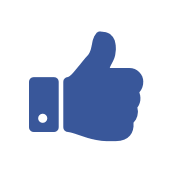 <b>Please leave an upvote if you found the notebook to be useful. </b> <br/>

Comments / suggestions on improving the notebook are very much welcome. <br/>
Notebook is still work in progress..
